In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_dir = Path("D:/Datasets/fruits-360_dataset/fruits-360/Training/")
test_dir = Path("D:/Datasets/fruits-360_dataset/fruits-360/Test/")

In [3]:
def create_df(path):
    # creating a list of paths to all the files with the .jpg extension.
    filepaths = list(path.glob(r'**/*.jpg'))
    # creating a list of labels for each image.
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    # creating a DataFrame from the lists of filepaths and labels.
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepaths, labels], axis=1)
    
    return df

train = create_df(train_dir)
test = create_df(test_dir)
print('Train shape: ' , train.shape)
print('Test shape: ' , test.shape)

Train shape:  (29440, 2)
Test shape:  (9979, 2)


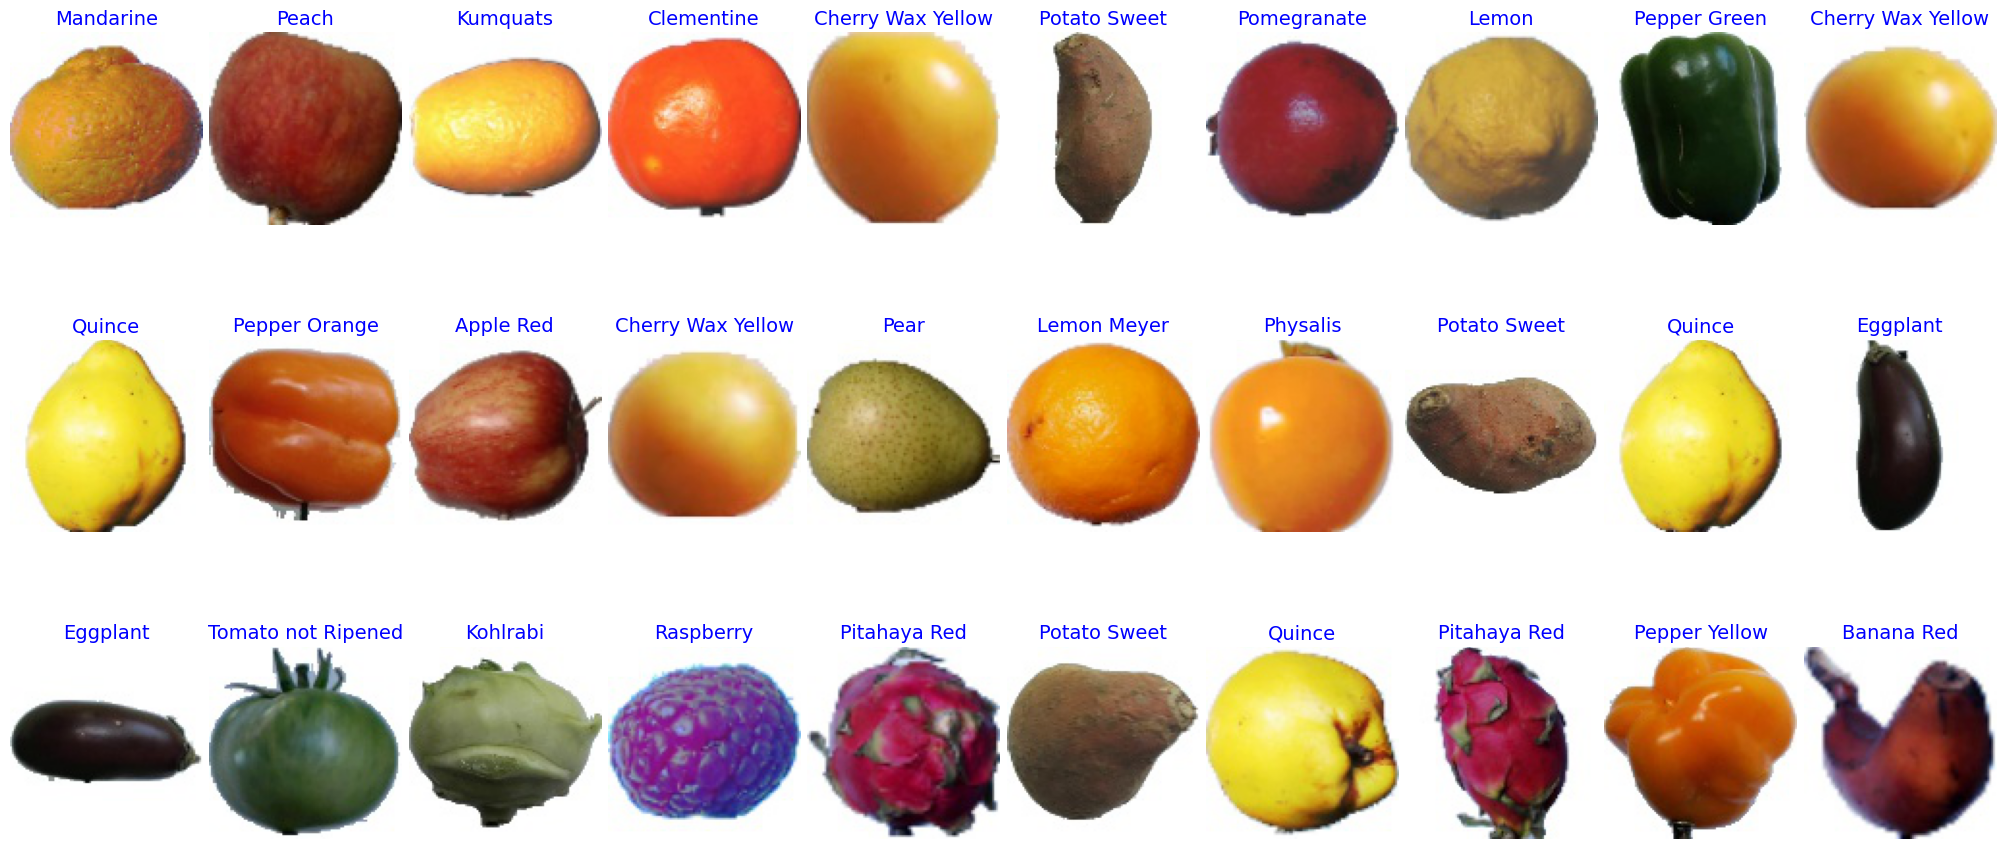

In [4]:
random_img = train.sample(30).reset_index()
fig, axes = plt.subplots(3, 10, figsize=(20, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(random_img.Filepath[i]))
    ax.set_title(random_img.Label[i], color='blue', fontsize=14)
    ax.axis('off')
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
train, val = train_test_split(train, test_size=0.2, random_state=42)
print('Train shape: ', train.shape)
print('Validation shape: ', val.shape)


Train shape:  (23552, 2)
Validation shape:  (5888, 2)


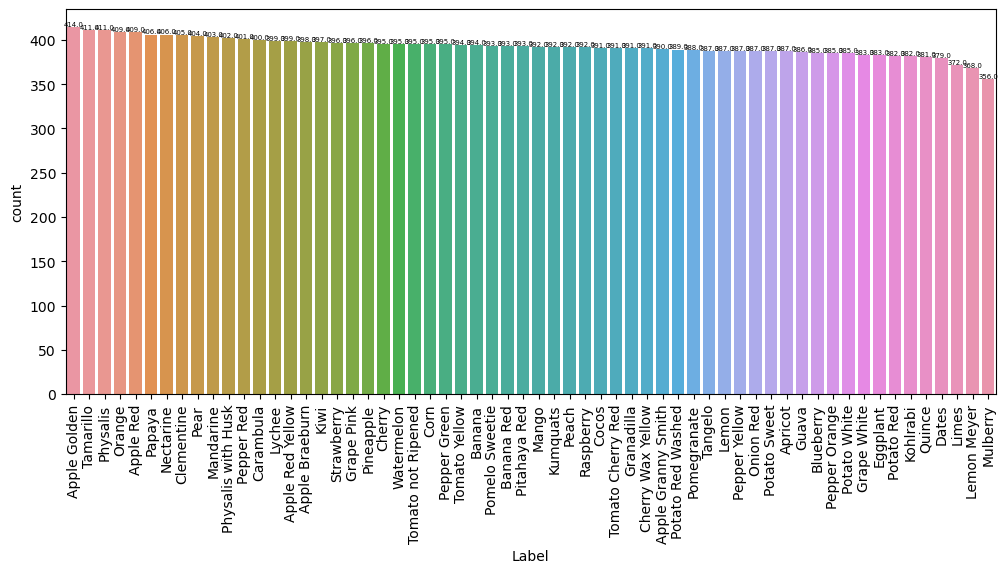

In [12]:
train_count = train['Label'].value_counts()
train_order = list(train_count.index)

plt.figure(figsize=(12, 5))

ax = sns.countplot(x='Label', data=train, order=train_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=5)
    ax.set_xticklabels(train_count.index, rotation=90)
    
plt.show()

In [13]:
gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

def progress_image(df, shuffle):
    img_batch = gen.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath',
        y_col='Label',
        target_size=(100, 100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=shuffle,
    )
    return img_batch


train_images = progress_image(train, True)
val_images = progress_image(val, False)
test_images = progress_image(test, False)

Found 23552 validated image filenames belonging to 60 classes.
Found 5888 validated image filenames belonging to 60 classes.
Found 9979 validated image filenames belonging to 60 classes.


In [16]:
def create_model(pretrained_model):

        inputs = pretrained_model.input

        dense_1 = layers.Dense(512, activation='relu')(pretrained_model.output)
        dropout_1 = layers.Dropout(0.5)(dense_1)

        dense_2 = layers.Dense(128, activation='relu')(dropout_1)
        dropout_2 = layers.Dropout(0.5)(dense_2)

        outputs = layers.Dense(60, activation='softmax')(dropout_2)

        model = Model(inputs, outputs)

        model.compile(optimizer=Adam(lr=1e-5),
                      loss= 'categorical_crossentropy',
                      metrics=['accuracy'])

        return model

pretrained_model = tf.keras.applications.resnet50.ResNet50(input_shape=(100, 100, 3), include_top=False, weights='imagenet', pooling='avg')

model = create_model(pretrained_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

In [17]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    batch_size=32,
    callbacks=[
        ModelCheckpoint(
            filepath = 'D:/Github/ML/new_checkpoints/resnet50_checkpoint_{epoch:02d}.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='auto',
            save_freq = 'epoch'
        ),

        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True    
        )
    ]
)

Epoch 1/50
736/736 [==============================] - 2178s 3s/step - loss: 3.0512 - accuracy: 0.2697 - val_loss: 0.7905 - val_accuracy: 0.9730
Epoch 2/50
736/736 [==============================] - 2193s 3s/step - loss: 1.0425 - accuracy: 0.7538 - val_loss: 0.0293 - val_accuracy: 0.9998
Epoch 3/50
736/736 [==============================] - 2101s 3s/step - loss: 0.3520 - accuracy: 0.9243 - val_loss: 8.8323e-04 - val_accuracy: 1.0000
Epoch 4/50
736/736 [==============================] - 2154s 3s/step - loss: 0.1713 - accuracy: 0.9644 - val_loss: 8.8826e-05 - val_accuracy: 1.0000
Epoch 5/50
736/736 [==============================] - 2177s 3s/step - loss: 0.1015 - accuracy: 0.9801 - val_loss: 1.7169e-05 - val_accuracy: 1.0000
Epoch 6/50
736/736 [==============================] - 2126s 3s/step - loss: 0.0680 - accuracy: 0.9870 - val_loss: 4.6353e-06 - val_accuracy: 1.0000
Epoch 7/50
736/736 [==============================] - 2080s 3s/step - loss: 0.0516 - accuracy: 0.9896 - val_loss: 1.6802

In [18]:
model.save('D:/Github/ML/models/resnet50_model.h5')

In [65]:
results = model.evaluate(test_images, verbose=1)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

312/312 [==============================] - 158s 507ms/step - loss: 0.0234 - accuracy: 0.9941
Test Loss: 0.02345
Test Accuracy: 99.41%


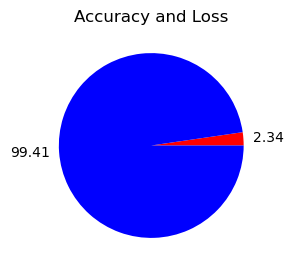

In [101]:
loss, acc = results
plt.figure(figsize=(3, 3))
plt.pie([loss, acc], labels=[round(loss*100, 2), round(acc*100, 2)], colors=['red', 'blue'])
plt.title('Accuracy and Loss', fontsize=12)
plt.show()

In [69]:
preds = np.argmax(model.predict(test_images), axis=1);

test_labels = test_images.classes
class_names = list(test_images.class_indices.keys())

print('Classification report:\n\n', classification_report(test_labels, preds, target_names=class_names))

312/312 [==============================] - 141s 452ms/step
Classification report:

                     precision    recall  f1-score   support

    Apple Braeburn       0.99      1.00      1.00       164
      Apple Golden       1.00      1.00      1.00       164
Apple Granny Smith       1.00      1.00      1.00       164
         Apple Red       1.00      1.00      1.00       164
  Apple Red Yellow       1.00      1.00      1.00       164
           Apricot       1.00      1.00      1.00       164
            Banana       1.00      1.00      1.00       166
        Banana Red       1.00      1.00      1.00       166
         Blueberry       1.00      1.00      1.00       154
         Carambula       1.00      1.00      1.00       166
            Cherry       1.00      1.00      1.00       246
 Cherry Wax Yellow       1.00      1.00      1.00       164
        Clementine       1.00      1.00      1.00       166
             Cocos       1.00      1.00      1.00       166
              C

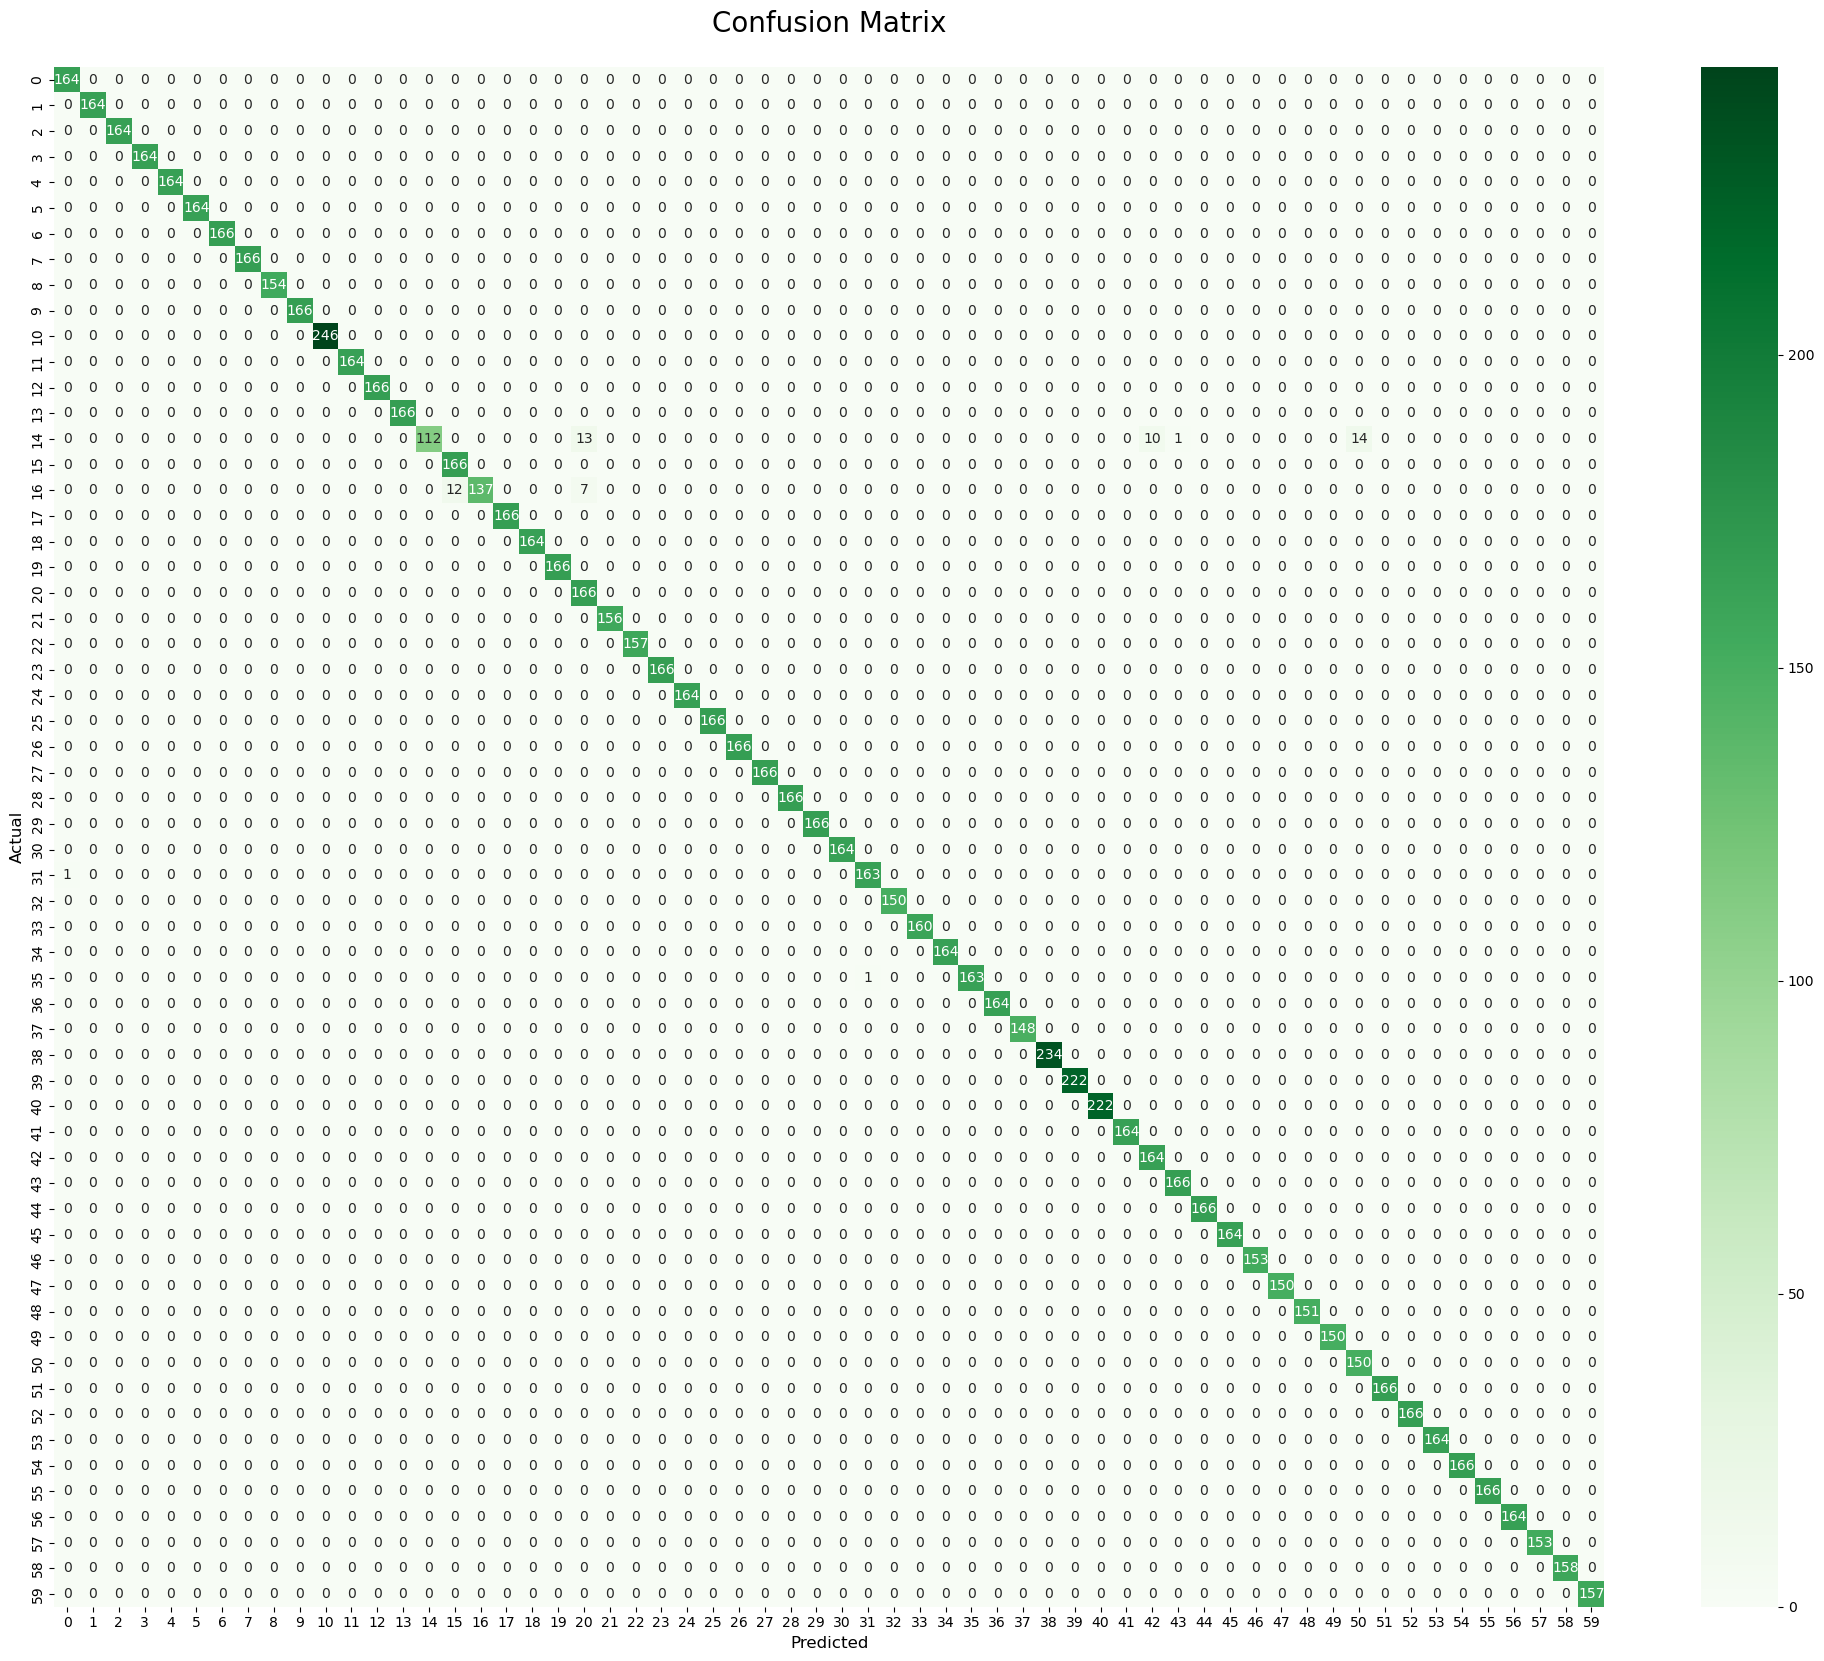

In [70]:
fig, ax =plt.subplots(figsize=(25, 20))
c_mat = confusion_matrix(test_images.labels, preds)

ax=sns.heatmap(c_mat, cmap="Greens", annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=20, pad=25)
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)
plt.show()

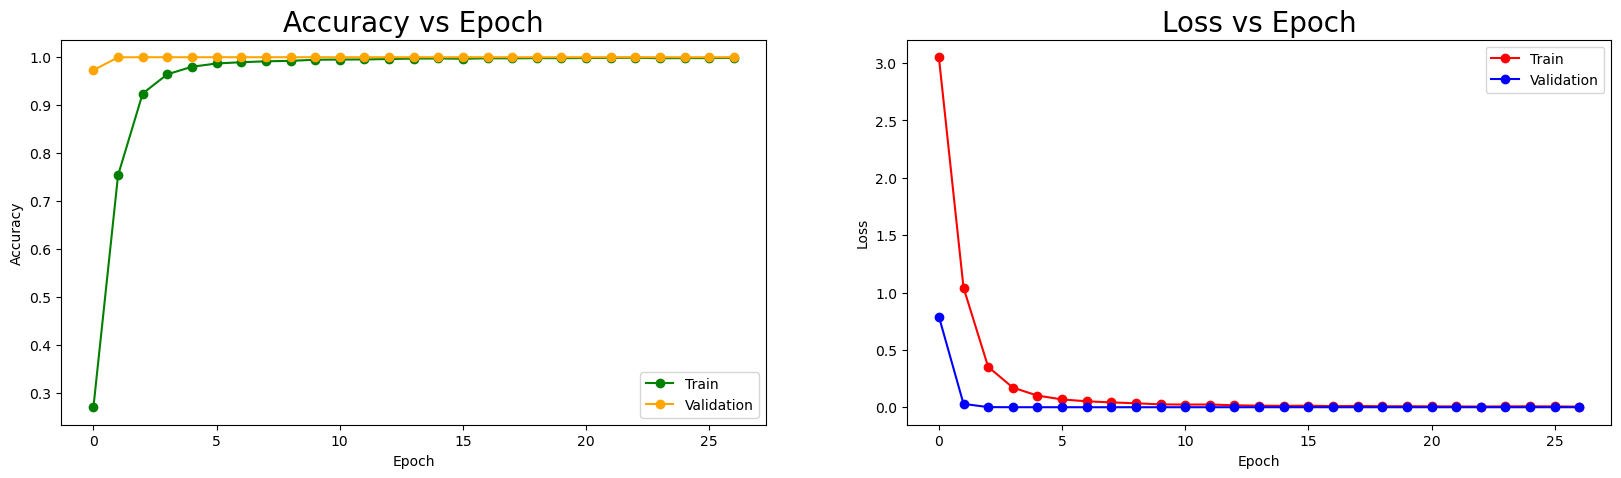

In [73]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', color='green')
plt.plot(history.history['val_accuracy'], 'o-', color='orange')
plt.title('Accuracy vs Epoch', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', color='red')
plt.plot(history.history['val_loss'], 'o-', color='blue')
plt.title('Loss vs Epoch', fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

1/1 [==============================] - 0s 186ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

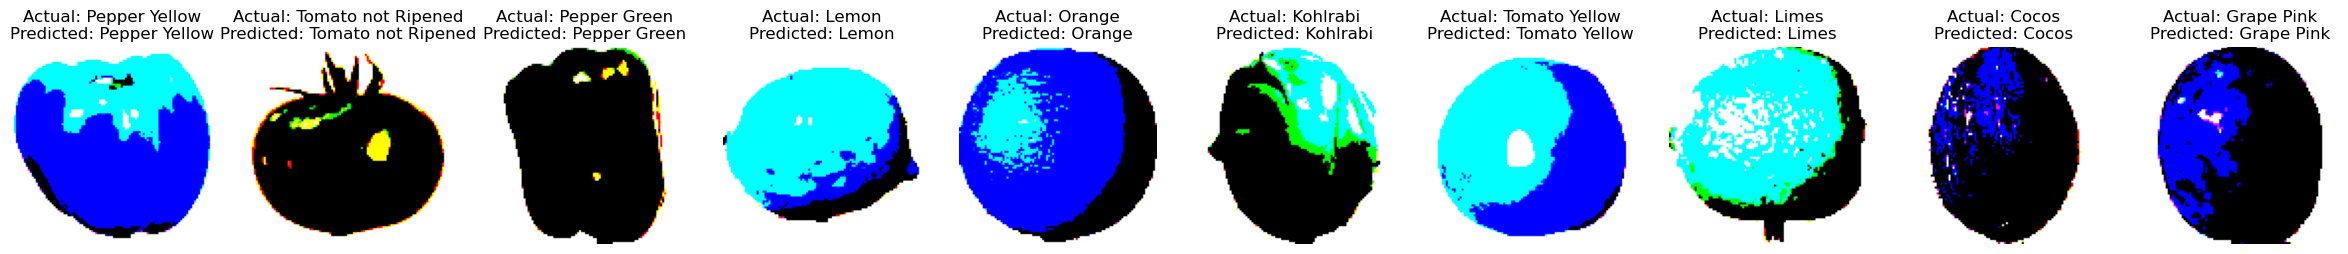

In [64]:
test_batch = next(test_images)
images = test_batch[0][15:25]
labels = test_batch[1][15:25]


predictions = np.argmax(model.predict(images), axis=1)


fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(10):
    img = images[i]
    label = class_names[np.argmax(labels[i])]
    pred = class_names[predictions[i]]
    ax[i].imshow(img)
    ax[i].set_title(f'Actual: {label}\nPredicted: {pred}')
    ax[i].axis('off')
plt.show()